In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
palette1 = sns.color_palette()
palette2 = sns.color_palette("hls",5)
palette_greys = sns.color_palette("Greys",5)

In [18]:
def rename(df):
    df['modelname'] = df['modelname'].replace('euclidean', 'Least squares K-means \n (sign-flipped eigenvectors)')
    df['modelname'] = df['modelname'].replace('diametrical', 'Diametrical clustering')
    df['modelname'] = df['modelname'].replace('Complex_diametrical', 'Complex diametrical clustering')
    df['modelname'] = df['modelname'].replace('grassmann', 'Grassmann clustering')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'Weighted Grassmann clustering')
    # df['modelname'] = df['modelname'].replace('Watson', 'Watson mixture')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Complex Watson')
    # df['modelname'] = df['modelname'].replace('ACG', 'ACG mixture')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Complex ACG')
    # df['modelname'] = df['modelname'].replace('MACG', 'MACG mixture')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Singular Wishart')
    
# if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = []
    names2 = []
    group = []
    for i in range(len(df)):
        if df['HMM'][i]:
            add_HMM = ' HMM'
        else:
            add_HMM = ''
        if df['modelname'][i] in ['ACG','Complex ACG','MACG','Singular Wishart']:
            names.append(df['modelname'][i]+' rank='+str(df['rank'][i]))
            names2.append(df['modelname'][i]+' rank='+str(df['rank'][i])+add_HMM)
        else:
            names.append(df['modelname'][i])
            names2.append(df['modelname'][i]+add_HMM)
        if df['LR'][i]==0:
            group.append('EM')
        elif df['LR'][i]==0.1 and not df['HMM'][i]:
            group.append('Torch')
        elif df['LR'][i]==0.1 and df['HMM'][i]:
            group.append('HMM')
            
    df['names'] = names
    df['names2'] = names2
    df['group'] = group
    return df

In [19]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'
df1 = pd.read_csv(data_folder+'phase_narrowband_controlled_euclidean.csv')
df2 = pd.read_csv(data_folder+'phase_narrowband_controlled_diametrical.csv')
df3 = pd.read_csv(data_folder+'phase_narrowband_controlled_Complex_diametrical.csv')
df4 = pd.read_csv(data_folder+'phase_narrowband_controlled_grassmann.csv')
df5 = pd.read_csv(data_folder+'phase_narrowband_controlled_weighted_grassmann.csv')
df_kmeans = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df_kmeans = rename(df_kmeans)

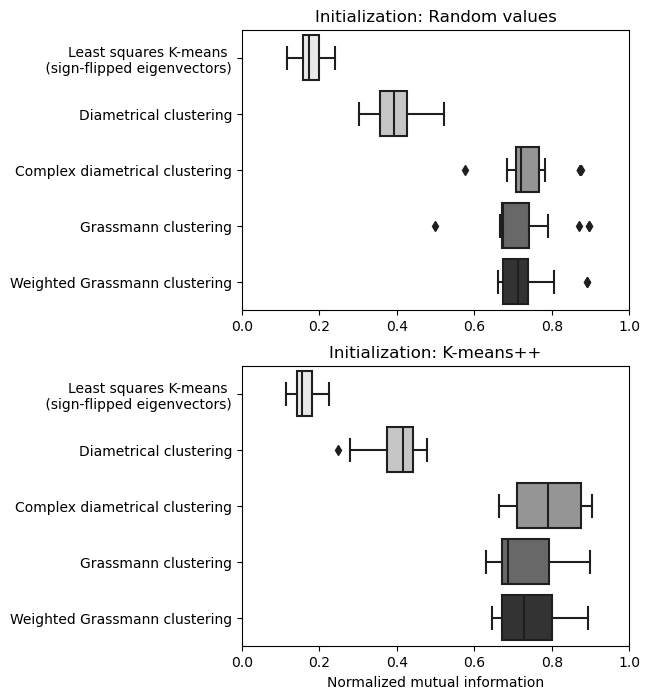

In [20]:
fig,axs = plt.subplots(2,1,figsize=(5,8), sharey=True)
sns.boxplot(x='train_NMI', y='names', data=df_kmeans[df_kmeans['init']=='unif'], ax=axs[0], palette=palette_greys)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title('Initialization: Random values')
axs[0].set_xlim([0,1])
sns.boxplot(x='train_NMI', y='names', data=df_kmeans[df_kmeans['init']=='++'], ax=axs[1], palette=palette_greys)
axs[1].set_xlabel('Normalized mutual information')
axs[1].set_ylabel('')
axs[1].set_title('Initialization: K-means++')
axs[1].set_xlim([0,1])
fig.savefig('figures/torchvsEM_phase_narrowband_controlled_results_kmeans.png', bbox_inches='tight', dpi=300)

In [21]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'

df = pd.DataFrame()
for model in ['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart']:
    for init in ['unif','Kmeans','Kmeansseg','ALL']:
        data = pd.read_csv(data_folder+'phase_narrowband_controlled_'+model+'_init'+init+'.csv')
        data = rename(data)
        if init == 'ALL':
            data['initialization'] = 'All'
        elif init == 'Kmeansseg':
            data['initialization'] = 'Analytical \n maximization'
        elif init == 'Kmeans':
            data['initialization'] = 'K-means'
        elif init == 'unif':
            data['initialization'] = 'Random'

        # data['initialization'] = init
        df = pd.concat([df, data], ignore_index=True)

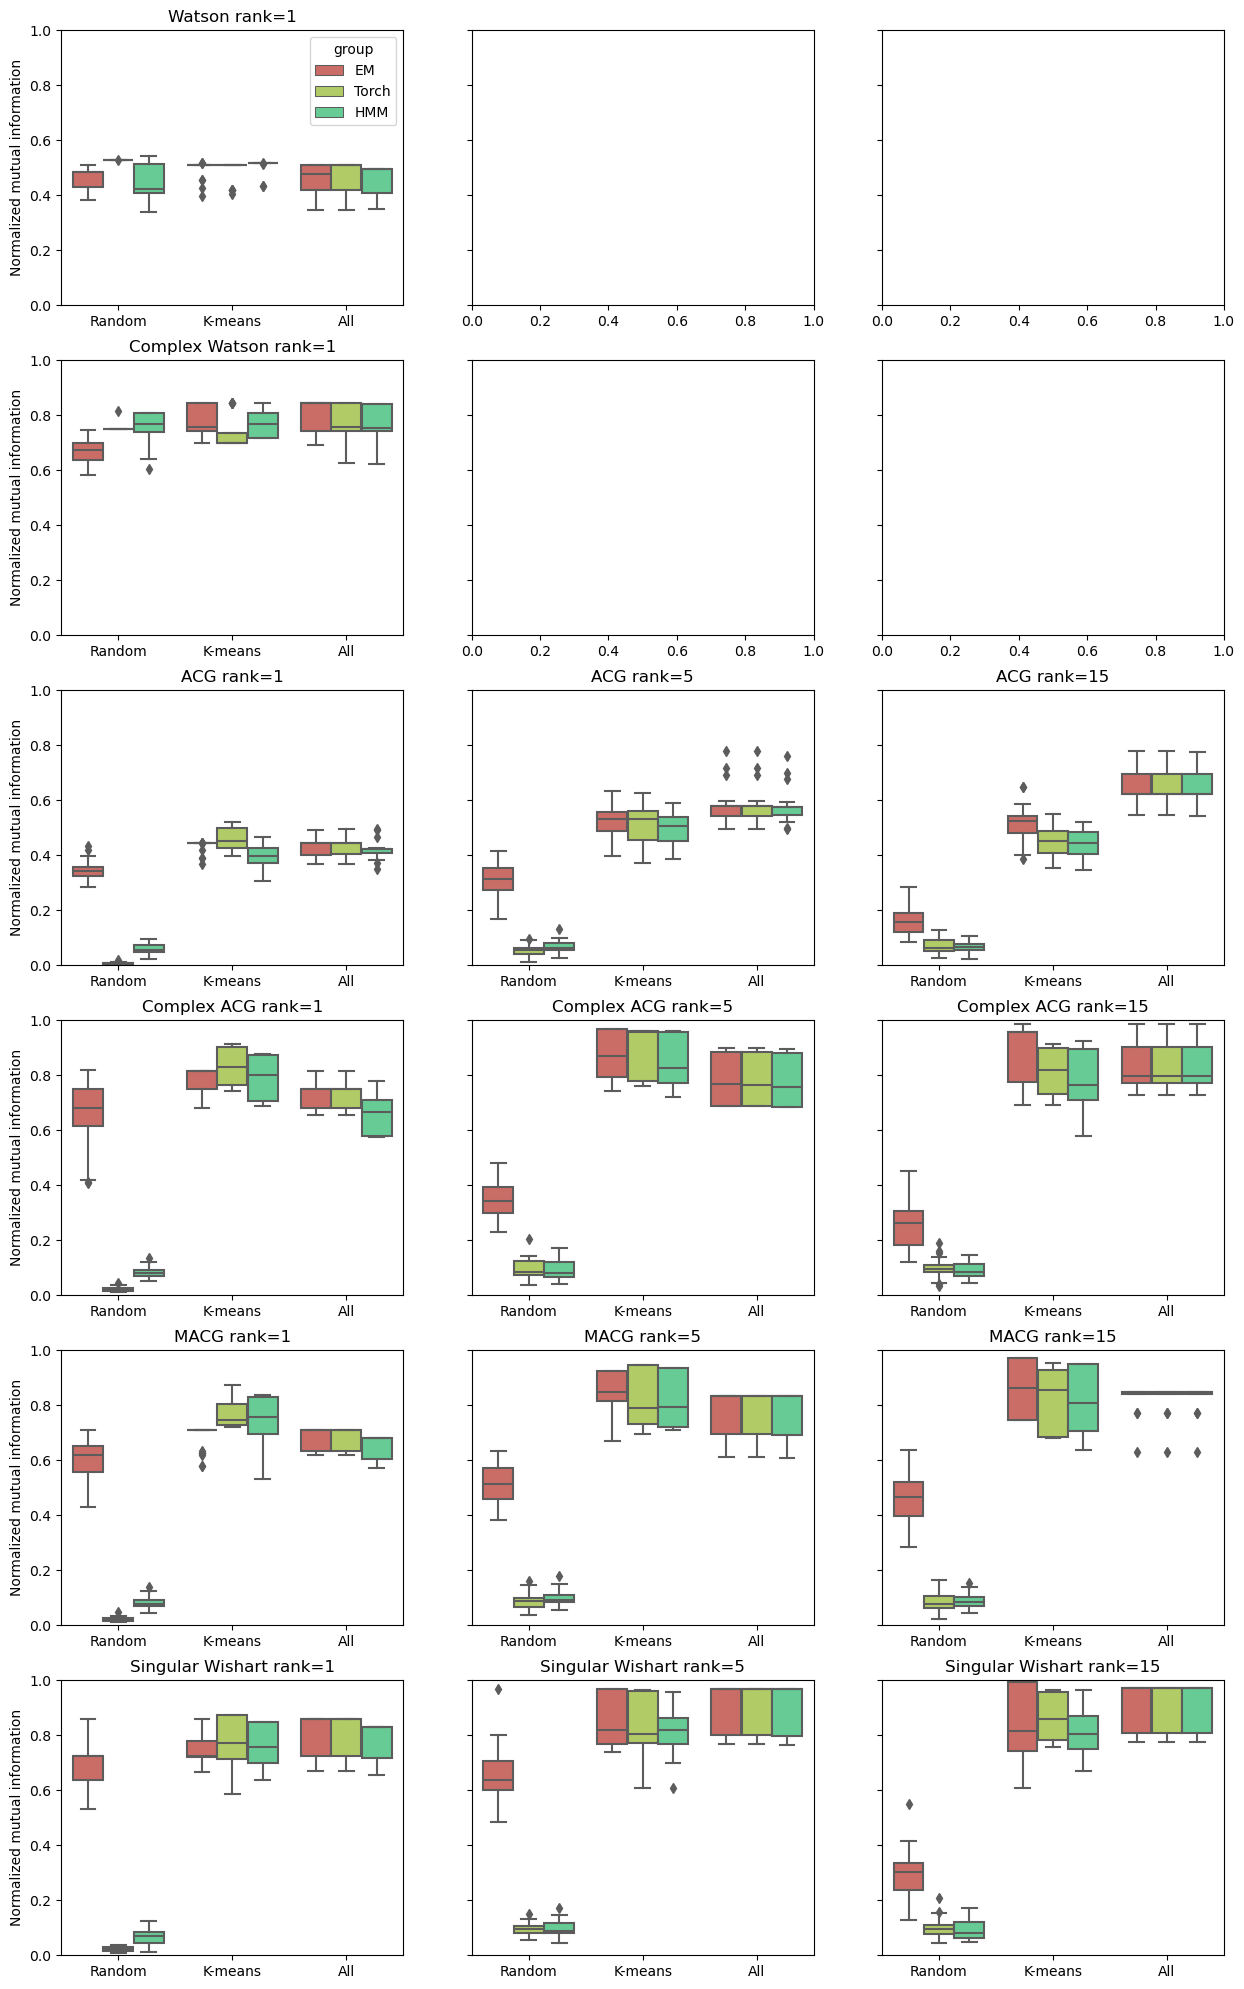

In [22]:
fig,axs = plt.subplots(6,3,figsize=(15,25), sharey=True)
for i,models in enumerate(['Watson','Complex Watson','ACG','Complex ACG','MACG','Singular Wishart']):
    for j,rank in enumerate([1,5,15]):
        if rank!=1 and models in ['Watson','Complex Watson']:
            continue
        df0 = df[df['modelname']==models]
        df1 = df0[df0['rank']==rank]
        df1 = df1[df1['initialization']!='Analytical \n maximization']
        sns.boxplot(y='train_NMI', x='initialization',hue='group', data=df1, ax=axs[i,j], palette=palette2)
        axs[i,j].set_title(models+' rank='+str(rank))
        axs[i,j].set_ylim([0,1])
        if j!=0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('Normalized mutual information')
        # if i!=3:
        axs[i,j].set_xlabel('')
        if i!=0 or j!=0:
            axs[i,j].get_legend().remove()
        # axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results.png', bbox_inches='tight', dpi=300)

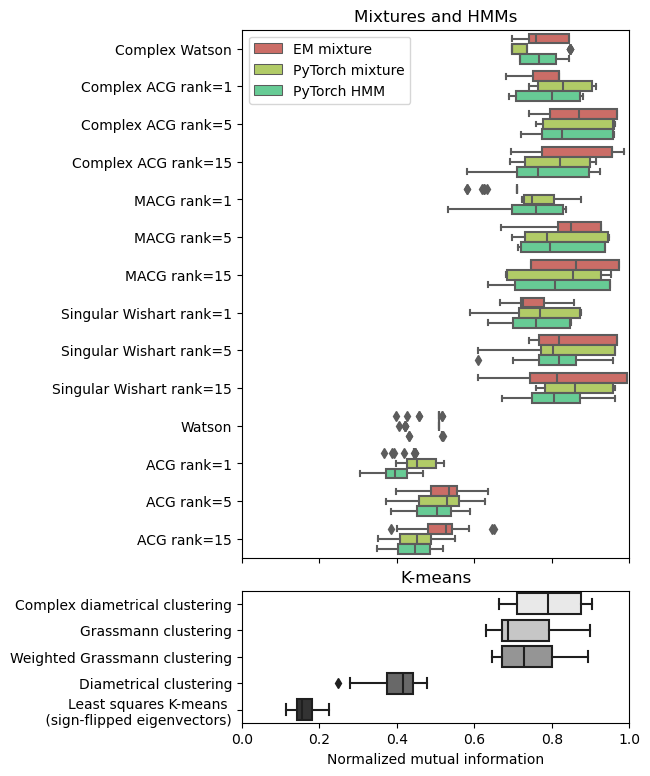

In [23]:
fig = plt.figure(figsize=(5,9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.1)

df_kmeans2 = df_kmeans[df_kmeans['init']=='++']
df_kmeans_signflip = df_kmeans2[df_kmeans2['modelname']=='Least squares K-means \n (sign-flipped eigenvectors)']
df_dc = df_kmeans2[df_kmeans2['modelname']=='Diametrical clustering']
df_cdc = df_kmeans2[df_kmeans2['modelname']=='Complex diametrical clustering']
df_gc = df_kmeans2[df_kmeans2['modelname']=='Grassmann clustering']
df_wgc = df_kmeans2[df_kmeans2['modelname']=='Weighted Grassmann clustering']
# df_km = pd.concat([df_kmeans_signflip,df_dc,df_cdc,df_gc,df_wgc], ignore_index=True)
df_km = pd.concat([df_cdc,df_gc,df_wgc,df_dc,df_kmeans_signflip], ignore_index=True)

ax1 = fig.add_subplot(gs[1])
ax1 = sns.boxplot(x='train_NMI',y='names',data=df_km, palette=palette_greys, ax=ax1)
# sns.swarmplot(x='train_NMI',y='names',data=df_km, color='k', ax=ax1, size=3)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('K-means')
ax1.set_xlim([0,1])
ax1.set_xlabel('Normalized mutual information')

df_fig1 = df[df['initialization']=='K-means']
df_fig1 = df_fig1[df_fig1['modelname']!='Singular Wishart']
df_fig2 = df[df['initialization']=='K-means']
df_fig2 = df_fig2[df_fig2['modelname']=='Singular Wishart']
df_fig = pd.concat([df_fig1,df_fig2], ignore_index=True)

order = ['Complex Watson', 'Complex ACG rank=1','Complex ACG rank=5','Complex ACG rank=15',
         'MACG rank=1','MACG rank=5','MACG rank=15',
         'Singular Wishart rank=1','Singular Wishart rank=5','Singular Wishart rank=15',
         'Watson', 'ACG rank=1','ACG rank=5','ACG rank=15']

ax2 = fig.add_subplot(gs[0])
ax2 = sns.boxplot(x='train_NMI',y='names',hue='group',data=df_fig, palette=palette2, ax=ax2, order=order)
ax2.set_title('Mixtures and HMMs')
ax2.set_xlabel('')
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1],labels=[])
plt.xlim([0,1])
labels = ["EM mixture", "PyTorch mixture", "PyTorch HMM"]
handles, _ = ax2.get_legend_handles_labels()
plt.legend(handles=handles,labels=labels,loc='upper left')
plt.ylabel('')
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_summarized.png', bbox_inches='tight', dpi=300)

165


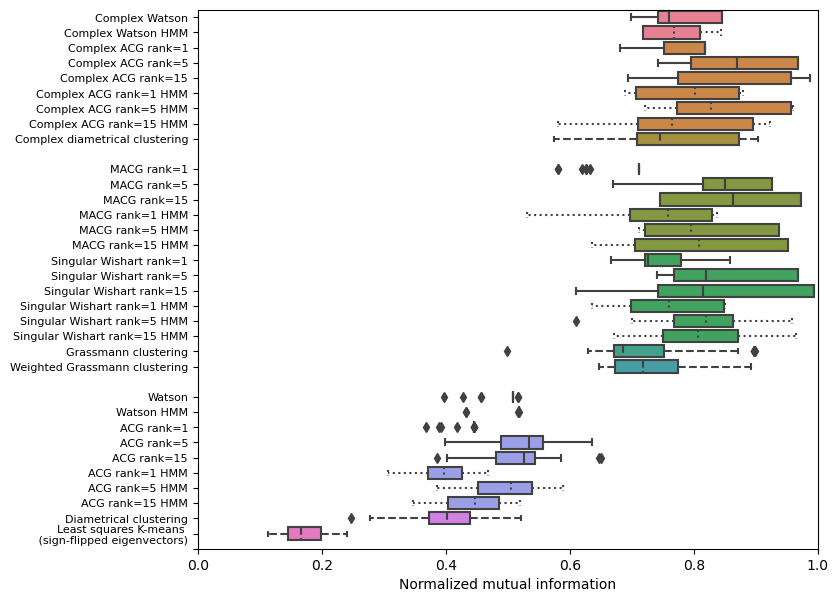

In [103]:
order = ['Complex Watson','Complex Watson HMM', 
         'Complex ACG rank=1','Complex ACG rank=5','Complex ACG rank=15',
         'Complex ACG rank=1 HMM','Complex ACG rank=5 HMM','Complex ACG rank=15 HMM',
         'Complex diametrical clustering','',
         'MACG rank=1','MACG rank=5','MACG rank=15',
         'MACG rank=1 HMM','MACG rank=5 HMM','MACG rank=15 HMM',
         'Singular Wishart rank=1','Singular Wishart rank=5','Singular Wishart rank=15',
         'Singular Wishart rank=1 HMM','Singular Wishart rank=5 HMM','Singular Wishart rank=15 HMM',
         'Grassmann clustering','Weighted Grassmann clustering','',
         'Watson', 'Watson HMM',
         'ACG rank=1','ACG rank=5','ACG rank=15',
         'ACG rank=1 HMM','ACG rank=5 HMM','ACG rank=15 HMM',
         'Diametrical clustering','Least squares K-means \n (sign-flipped eigenvectors)']
styles = ['-']+[':']+['-']*3+[':']*3+['--']+['-']*3+[':']*3+['-']*3+[':']*3+['--']*2+['-']+[':']+['-']*3+[':']*3+['--']*2
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl2 = [palette_husl[0]]*2+[palette_husl[1]]*6+[palette_husl[2]]*2+[palette_husl[3]]*6+[palette_husl[4]]*6+[palette_husl[5]]+[palette_husl[6]]*2+[palette_husl[7]]*2+[palette_husl[8]]*6+[palette_husl[9]]+[palette_husl[10]]

df2 = df[df['group']!='Torch']
df_fig1 = df2[df2['initialization']=='K-means']
df_fig1 = df_fig1[df_fig1['modelname']!='Singular Wishart']
df_fig2 = df2[df2['initialization']=='K-means']
df_fig2 = df_fig2[df_fig2['modelname']=='Singular Wishart']
df_fig = pd.concat([df_fig1,df_fig2,df_kmeans], ignore_index=True)

fig = plt.figure(figsize=(8,7))
sns.boxplot(x='train_NMI', y='names2', data=df_fig, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information')
plt.ylabel('')
plt.xlim([0,1])
plt.yticks(np.concatenate([np.arange(9),np.arange(14)+10,np.arange(11)+25]),fontsize=8)

# change the line styles
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1
print(l)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_summarized2.png', bbox_inches='tight', dpi=300)

95


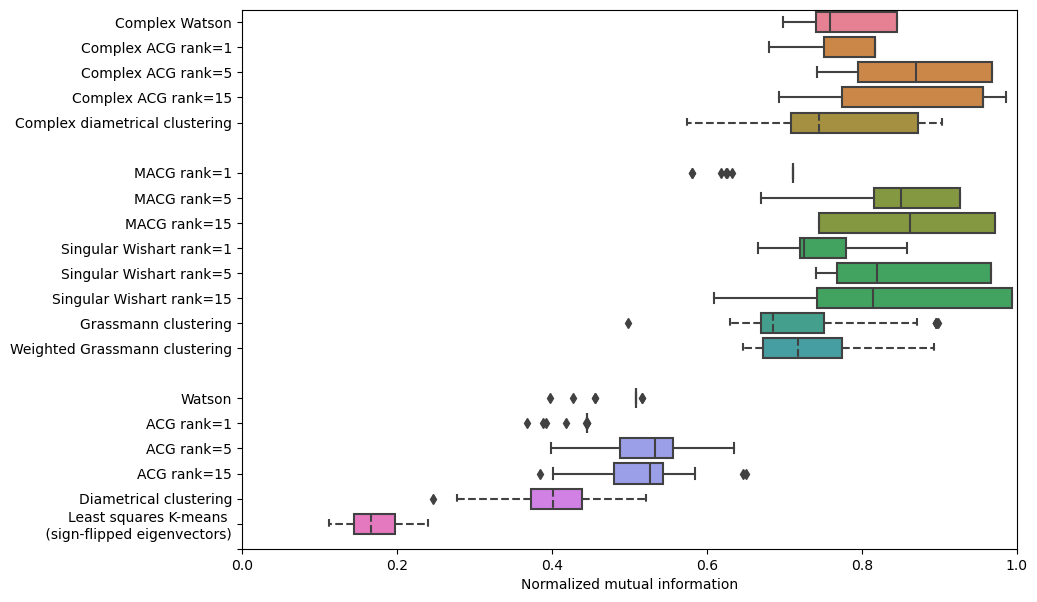

In [104]:
order = ['Complex Watson',
         'Complex ACG rank=1','Complex ACG rank=5','Complex ACG rank=15',
         'Complex diametrical clustering','',
         'MACG rank=1','MACG rank=5','MACG rank=15',
         'Singular Wishart rank=1','Singular Wishart rank=5','Singular Wishart rank=15',
         'Grassmann clustering','Weighted Grassmann clustering','',
         'Watson', 
         'ACG rank=1','ACG rank=5','ACG rank=15',
         'Diametrical clustering','Least squares K-means \n (sign-flipped eigenvectors)']
styles = ['-']+['-']*3+['--']+['-']*3+['-']*3+['--']*2+['-']+['-']*3+['--']*2
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl2 = [palette_husl[0]]+[palette_husl[1]]*3+[palette_husl[2]]*2+[palette_husl[3]]*3+[palette_husl[4]]*3+[palette_husl[5]]+[palette_husl[6]]*2+[palette_husl[7]]+[palette_husl[8]]*3+[palette_husl[9]]+[palette_husl[10]]

df2 = df[df['group']!='Torch']
df_fig1 = df2[df2['initialization']=='K-means']
df_fig1 = df_fig1[df_fig1['modelname']!='Singular Wishart']
df_fig2 = df2[df2['initialization']=='K-means']
df_fig2 = df_fig2[df_fig2['modelname']=='Singular Wishart']
df_fig = pd.concat([df_fig1,df_fig2,df_kmeans], ignore_index=True)

fig = plt.figure(figsize=(10,7))
sns.boxplot(x='train_NMI', y='names2', data=df_fig, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information')
plt.ylabel('')
plt.xlim([0,1])
plt.yticks(np.concatenate([np.arange(5),np.arange(8)+6,np.arange(7)+15]))

# change the line styles
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1
print(l)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_summarized3.png', bbox_inches='tight', dpi=300)